# Анализ пользовательского поведения в мобильном приложении


Здесь приведено аналитическое исследование маркетинга приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.
В нашем распоряжении данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года.

<b>Последовательность выполнения проекта:</b>

1. Загружаем данные и готовим их к анализу
2. Задаём функции для расчёта удержания, конверсии, а также LTV, ROI и CAC. Затем создаём функции для визуализации этих метрик
3. Проводим исследовательский анализ данных, в котором создаём профили пользователей и узнаём из каких они стран, какими девайсами пользуются, какой канал привлечения их привлёк и сколько они заплатили в данном сервисе
4. Изучаем траты на маркетинг - общие и в зависимости от канала привлечения
5. Оцениваем окупаемость рекламы с помощью основных метрик (LTV, ROI, CAC). Смотрим на окупаемость рекламы в разрезе устройст, стран и источников привлечения клиентов
6. Подводим выводы по проекту

### Загрузите данные и подготовьте их к анализу

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.



In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

Изучаем дату и выполняем предобработку:

In [3]:
display(visits.head())
visits.info()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
display(orders.head())
orders.info()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
display(costs.head())
costs.info()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


<b>Приведем названия столбцов к удобному виду:

In [6]:
for i in [visits, orders, costs]:
    i.columns = [x.lower().replace(' ', '_') for x in i.columns.values]

<b>Пропусков нет, изменим тип данных:

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [8]:
for i in (visits, orders, costs):
    print('Количество дубликатов:', i.duplicated().sum()) 

Количество дубликатов: 0
Количество дубликатов: 0
Количество дубликатов: 0


Полных дубликатов нет, значения в колонке уникального идентификатора user_id могут повторяться (один пользователь мог зайти несколько раз на сайт и сделать несколько заказов).

### Задаем функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [9]:
def get_profiles(sessions, orders, costs):
    # находим параметры первых посещений
    profiles = (sessions.sort_values(by=['user_id', 'session_start'])
                .groupby('user_id')
                .agg(
                    {
                        'session_start' : 'first',
                        'channel' : 'first',
                        'device' : 'first',
                        'region' : 'first'
                    }
                )
                .rename(columns={'session_start' : 'first_ts'})
                .reset_index()
               )
    
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак пользователей, совершивших покупку
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

In [10]:
# функция для подсчёта Retention Rate

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw  = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [13]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [14]:
# функция для построения графика Retention Rate
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [16]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [17]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [18]:
print(f'Минимальная дата привлечения: {profiles.first_ts.dt.date.min()}',
      f'Максимальная дата привлечения {profiles.first_ts.dt.date.max()}', sep='\n')

Минимальная дата привлечения: 2019-05-01
Максимальная дата привлечения 2019-10-27


<b>Согласно условию, задаём текущую дату и горизонт анализа:

In [19]:
observation_date = datetime(2019, 11, 1).date()  
horizon_days = 14  

<b> Выясняем распределение пользователей по странам:

In [20]:
region_users = (
    profiles.groupby('region')['user_id'].nunique().reset_index()
    .merge(profiles[profiles['payer']==True].groupby('region')['user_id'].nunique().reset_index(), 
           on = 'region', how = 'left')
)
region_users.set_axis(['region', 'total_users', 'payers'], axis='columns', inplace=True)
region_users['payer_rate'] = region_users.payers / region_users.total_users
display(region_users.sort_values(by='payer_rate', ascending=False))

,region,total_users,payers,payer_rate
3,United States,100002,6902,0.069019
1,Germany,14981,616,0.041119
2,UK,17575,700,0.039829
0,France,17450,663,0.037994


<b> Построим графики:

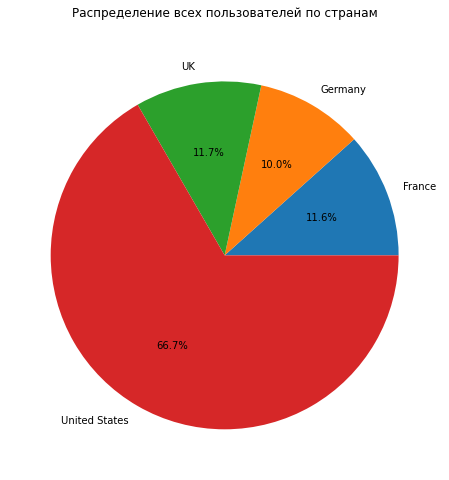

In [21]:
plt.figure(figsize=(8, 8))
plt.pie(region_users.total_users,
        labels = region_users.region,
        autopct='%1.1f%%'
       )

plt.title('Распределение всех пользователей по странам\n')
plt.show()

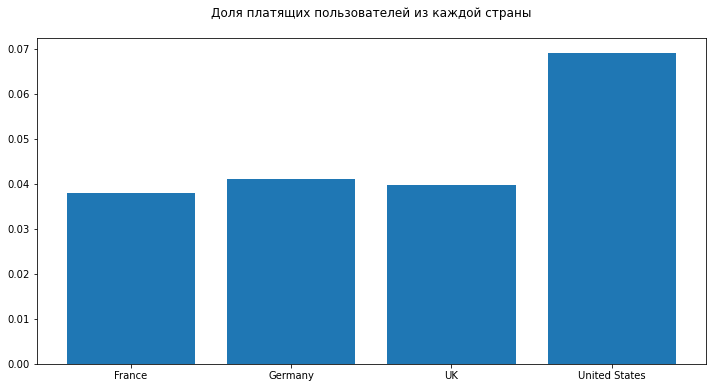

In [22]:
x = region_users.region
y = region_users.payer_rate

fig, ax = plt.subplots()

ax.bar(x, y)

fig.set_figwidth(12)    
fig.set_figheight(6)   
ax.set_title('Доля платящих пользователей из каждой страны\n')

plt.show()

Видно, что больше половины пользователей - из США, и процент платящих пользователей выше у американцев соответственно. В случае остальных стран различия не критичны. Теперь проанализируем клиентов с разными устройствами:

In [23]:
device_users = (
    profiles.groupby('device')['user_id'].nunique().reset_index()
    .merge(profiles[profiles['payer']==True].groupby('device')['user_id'].nunique().reset_index(), on = 'device', how = 'left')
)
device_users.set_axis(['device', 'total_users', 'payers'], axis='columns', inplace=True)
device_users['payer_rate'] = device_users.payers / device_users.total_users
device_users.sort_values(by='payer_rate', ascending=False)

,device,total_users,payers,payer_rate
1,Mac,30042,1912,0.063644
3,iPhone,54479,3382,0.062079
0,Android,35032,2050,0.058518
2,PC,30455,1537,0.050468


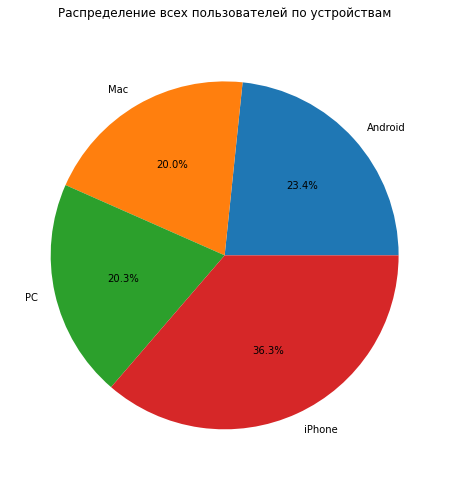

In [24]:
plt.figure(figsize=(8, 8))
plt.pie(device_users.total_users,
        labels = device_users.device,
        autopct='%1.1f%%'
       )

plt.title('Распределение всех пользователей по устройствам\n')
plt.show()

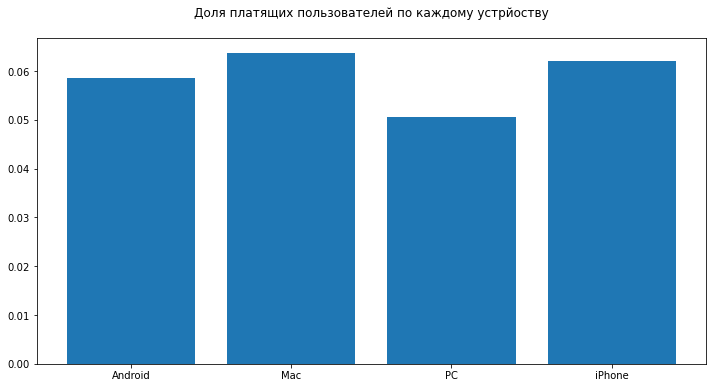

In [25]:
x = device_users.device
y = device_users.payer_rate

fig, ax = plt.subplots()

ax.bar(x, y)

fig.set_figwidth(12)    
fig.set_figheight(6)   
ax.set_title('Доля платящих пользователей по каждому устрйоству\n')

plt.show()

Большинство пользователей пользуются iPhone, на втором месте - Android, доля пользователей PC и Mac примерно равны. Видна закономерность - больше платящих среди пользователей продуктами Apple (iPhone и Mac), платящих среди пользователей Android и PC меньше. Перейдем к источникам привлечения:

In [26]:
ch_users = (
    profiles.groupby('channel')['user_id'].nunique().reset_index()
    .merge(profiles[profiles['payer']==True].groupby('channel')['user_id'].nunique().reset_index(), on = 'channel', how = 'left')
)
ch_users.set_axis(['channel', 'total_users', 'payers'], axis='columns', inplace=True)
ch_users['payer_rate'] = ch_users.payers / ch_users.total_users
ch_users.sort_values(by='payer_rate', ascending=False)

,channel,total_users,payers,payer_rate
1,FaceBoom,29144,3557,0.122049
0,AdNonSense,3880,440,0.113402
9,lambdaMediaAds,2149,225,0.104700
6,TipTop,19561,1878,0.096007
5,RocketSuperAds,4448,352,0.079137
7,WahooNetBanner,8553,453,0.052964
8,YRabbit,4312,165,0.038265
3,MediaTornado,4364,156,0.035747
2,LeapBob,8553,262,0.030633
4,OppleCreativeMedia,8605,233,0.027077


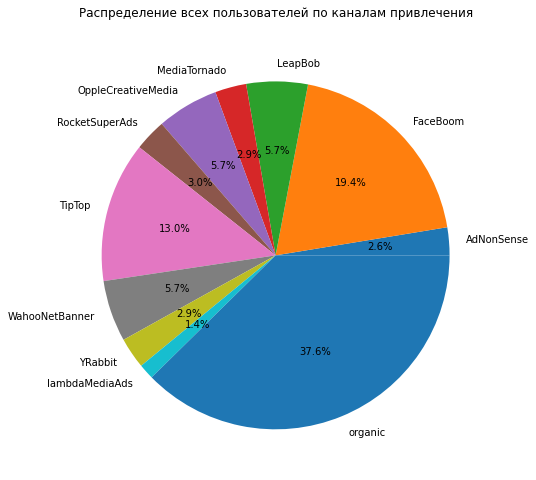

In [27]:
plt.figure(figsize=(8, 8))
plt.pie(ch_users.total_users,
        labels = ch_users.channel,
        autopct='%1.1f%%'
       )

plt.title('Распределение всех пользователей по каналам привлечения\n')

plt.show()

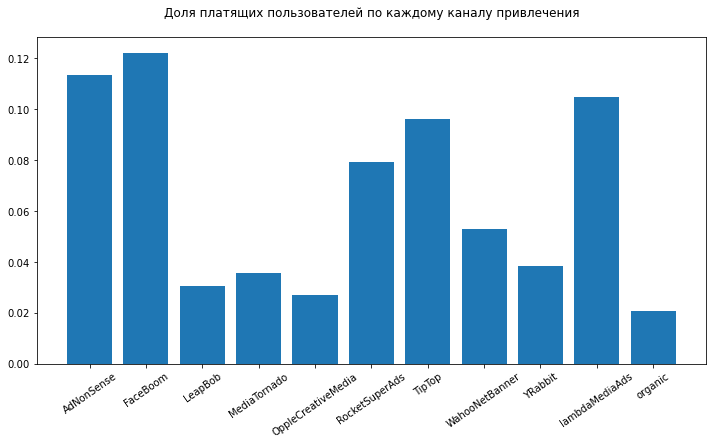

In [28]:
x = ch_users.channel
y = ch_users.payer_rate

fig, ax = plt.subplots()

ax.bar(x, y)

fig.set_figwidth(12)    
fig.set_figheight(6)   
ax.set_title('Доля платящих пользователей по каждому каналу привлечения\n')
plt.xticks(rotation = 35)
plt.show()

В таблице видим весь перечень каналов, по которым приходили пользователи.
Самый большое значение платящих пользователей у FaceBoom - 12,2%, на втором месте - AdNonSense 11,34%, на третьем месте - lambdaMediaAds 10.47%.

<b>Вывод:</b>

Диапазон привлечения клиентов 2019-05-01 - 2019-10-27
По таблице видно, что пользователи приходят из United States, Germany, UK, France. Больше всего платящих пользователей в United States - 6,9%.
Используемые устройства: Mac, iPhone, Android, PC. Чаще всего платящие пользователи используют Mac - 6,36%.
Самый большое значение платящих пользователей у канала FaceBoom - 12,2%, на втором месте - AdNonSense 11,34%, на третьем месте - lambdaMediaAds 10.47%. Так же видим болшое количество "органических" пользователей.

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. 
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

<b>Счиатем общую сумму:

In [29]:
c_sum = costs.costs.sum()
c_sum.round(2)

105497.3

<b> Группируем суммы по каналам привелчения:

In [30]:
ch_costs = costs.groupby('channel')['costs'].sum().sort_values(ascending=False)
ch_costs

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64

Лидеры по тратам - TipTop и FaceBoom. В предыдущих данных FaceBoom был на первой строчке по привлечению пользователей, а вот TipTop даже не в первой тройке. для наглядности также выведем процент затрат от общей суммы:

In [31]:
ch_costs / c_sum * 100

channel
TipTop                51.898295
FaceBoom              30.754910
WahooNetBanner         4.882589
AdNonSense             3.707441
OppleCreativeMedia     2.039152
RocketSuperAds         1.737485
LeapBob                1.703930
lambdaMediaAds         1.476436
MediaTornado           0.904744
YRabbit                0.895018
Name: costs, dtype: float64

<b>Построим визуализацию динамики изменения расходов во времени  по каждому источнику:

In [32]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


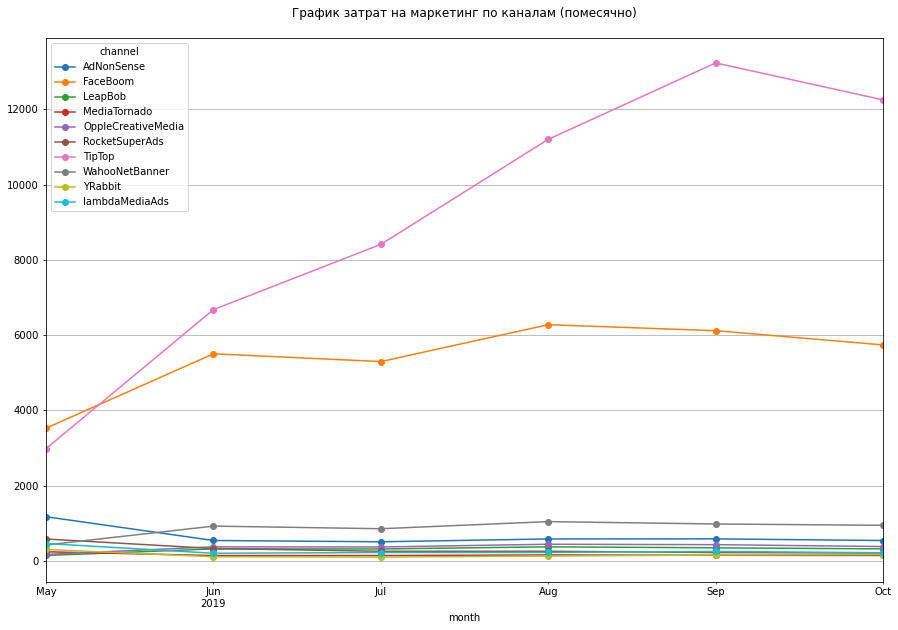

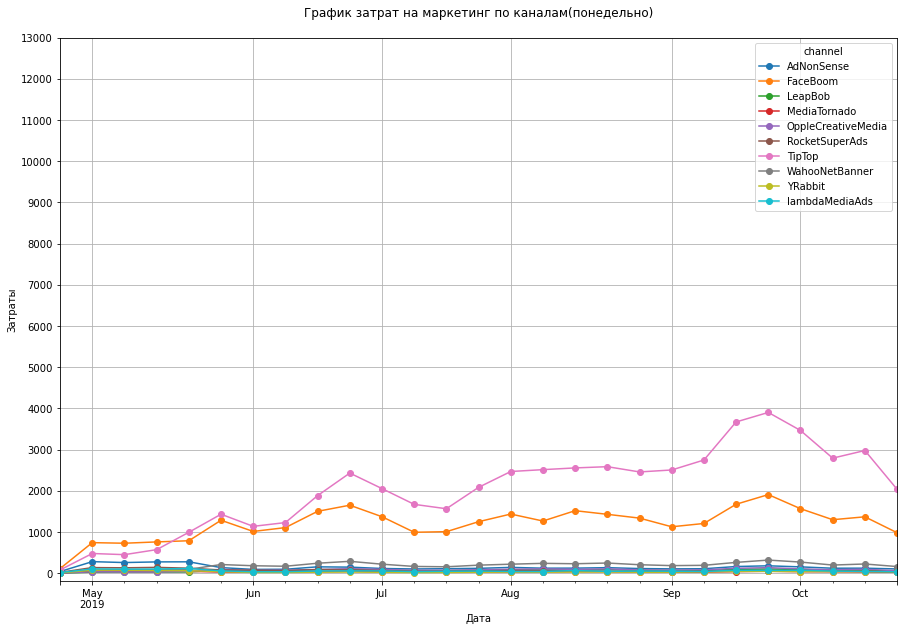

In [33]:
profiles = profiles.query('channel != "organic"')

week_pr = profiles.copy(deep=True)
week_pr['week'] = week_pr['first_ts'].astype('datetime64[W]')

m_channel_time = week_pr.pivot_table(index='month', 
                                      columns='channel', values='acquisition_cost', aggfunc='sum')
w_channel_time = week_pr.pivot_table(index='week', 
                                      columns='channel', values='acquisition_cost', aggfunc='sum')

m_channel_time.plot(figsize=(15, 10), grid=True, style='o-') 
plt.title('График затрат на маркетинг по каналам (помесячно)\n')

w_channel_time.plot(figsize=(15, 10), grid=True, style='o-') 
plt.title('График затрат на маркетинг по каналам(понедельно)\n')

plt.yticks(np.arange(0, 14000, 1000)) # зададим шаг по оси y


plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

Как по общим затратам, так и по стоимости привлечения пользователя лидирует канал TipTop. Треть затрат приходится на канал FaceBoom, но стоимость привлечения пользователя значительно ниже. График показывает, что затраты на рекламу в самом дорогостящем канале TipTop постоянно и значительно увеличивались, а в FaceBoom были выше, чем в других каналах, но стабильны.

<b>Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. 

In [34]:
profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)

channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
Name: acquisition_cost, dtype: float64

И рассчитаем средний САС для одного пользователя:

In [35]:
np.round(profiles['acquisition_cost'].mean(), 2)

1.13

Таким образом, привлечение из TipTop выше среднего значения больше, чем в два раза!

<b>Вывод</b>

Половина этой суммы потрачено на TipTop - 51,9%, следом FaceBoom - 30,75%, третье место - WahooNetBanner - 4,88%. Organic не имеет расходов, поэтому его убрали из анализа.

Как отметили ранее, основные траты на рекламу идут по каналам TipTop и FaceBoom. По каналу TipTop сумма в мае была примерно 3000, а в июне уже больше 6500. В сентябре было достигнуто максимальное значение - около 13000.
Так же затраты на каналы в июне выросли у WahooNetBanner, LeapBob, OppleCreativeMedia. По остальным источникам траты снижались. 

### Оценим окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Положим, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучите графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [36]:
new_profiles = profiles.query('channel != "organic"')

<b>Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Воспользуемся функциями, написанными ранее:

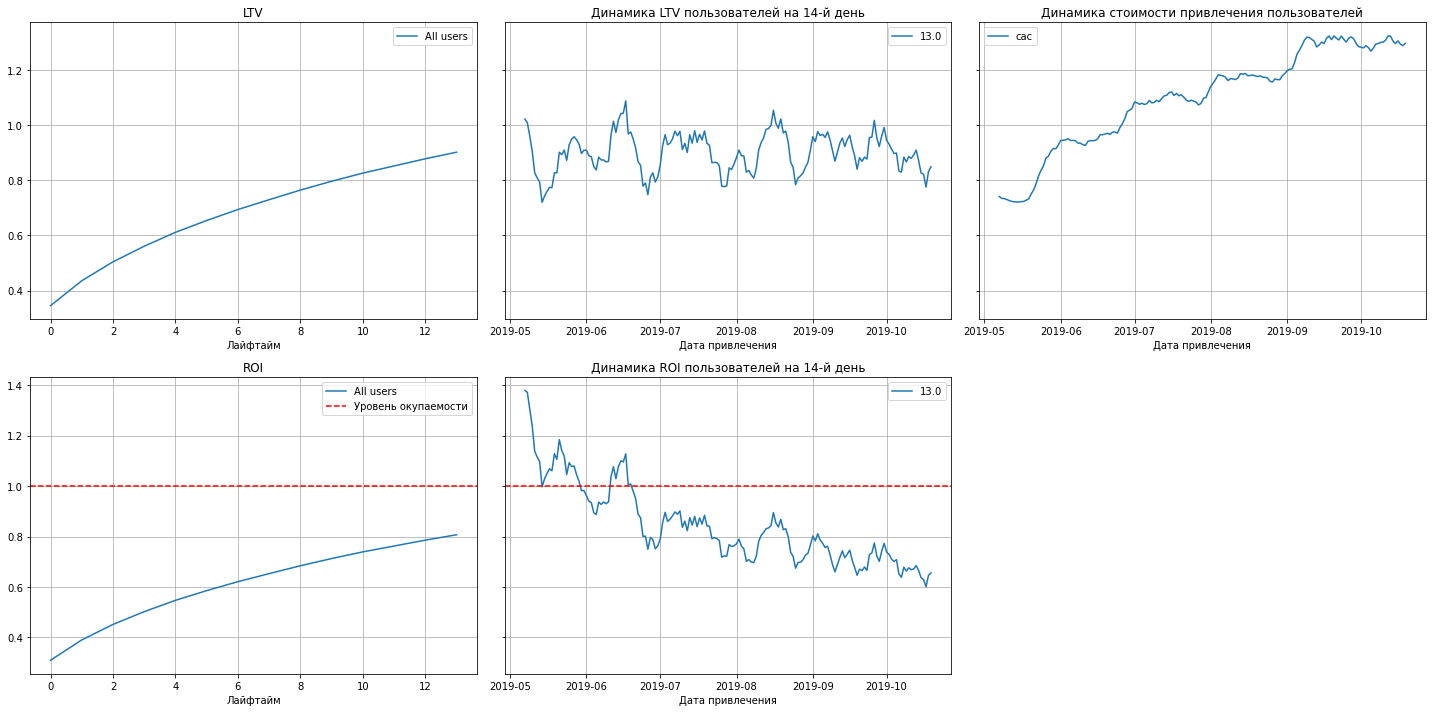

In [37]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(new_profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

<b>Вывод:</b>
Реклама не окупается к концу 2й недели. ROI — около 80%.
CAC нестабилен. Рекламный бюджет увеличивается с течением времени.
На LTV влияет сезонный фактор, но в целом, этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
ROI пользователей неумолимо падает. До июля показатель был выше уровня окупаемости, но после стал падать до 0.6.

<b>Теперь проанализируем окупаемость рекламы с разбивкой по устройствам:

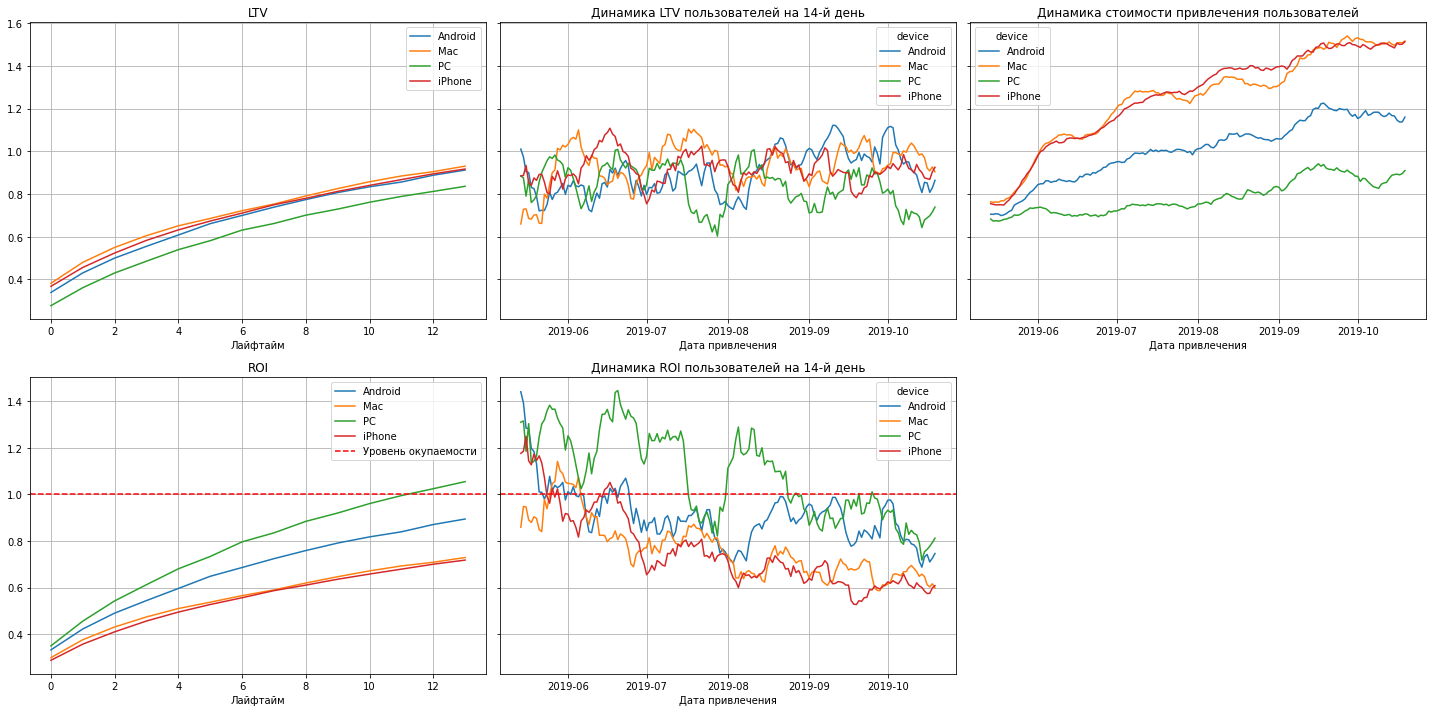

In [38]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    new_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Пользователи всех устройств окупались до июня, а потом что-то пошло не так, особенно для владельцев Mac и Iphone. К сентябрю (и какое-то время в августе) ROI пользователей PC на 14 день был на грани окупаемости, ROI всех остальных устройств был уже ниже уровня начиная с июня. LTV пользователей всё так же подвержен сезонности, но стабилен. Стоимость привлечения пользователей PC самая низкая, а ROI - наоборот, выше остальных. В целом, видим, что стоимость привлечения пользователей всех устройств росла за рассматриваемый период.

Направить внимание следует на владельцев Mac и iPhone - стоимость их привлечения высока (и растет от месяца к месяцу), а окупаемоcть страдает.

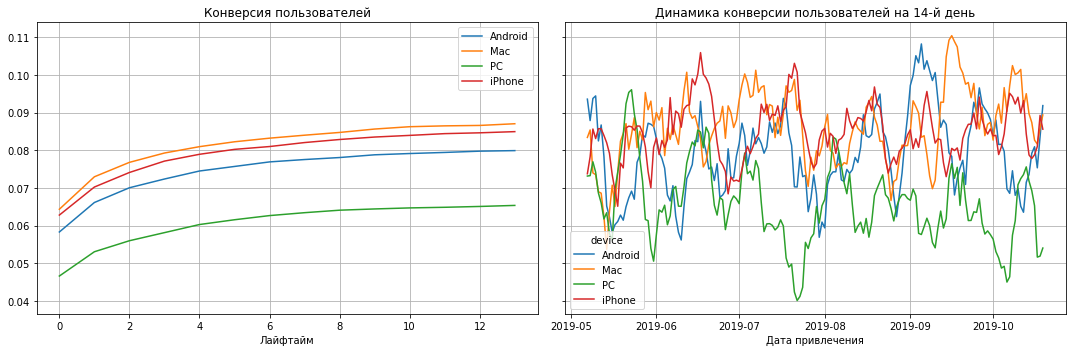

In [39]:
# конверсия с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    new_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

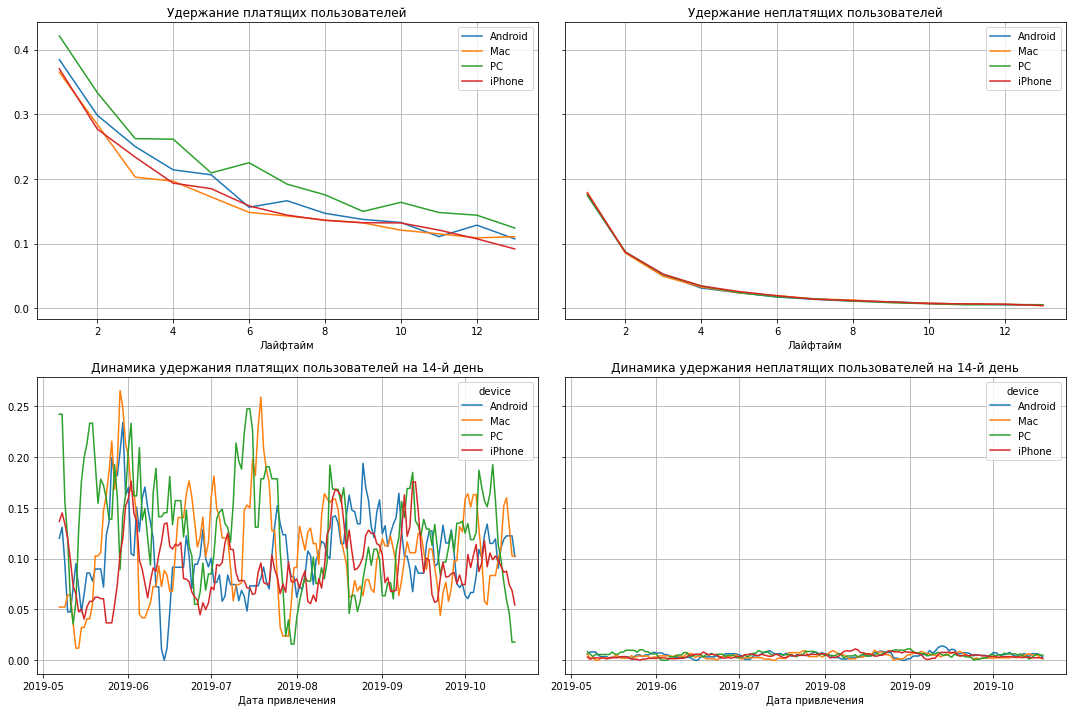

In [40]:
# удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    new_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days) 

Видим, что конверсия у пользователей Mac и iPhone лучше других двух устройств, а удержание примерно равномерное у всех устройств.

<b>Анализируем окупаемость рекламы с разбивкой по странам.

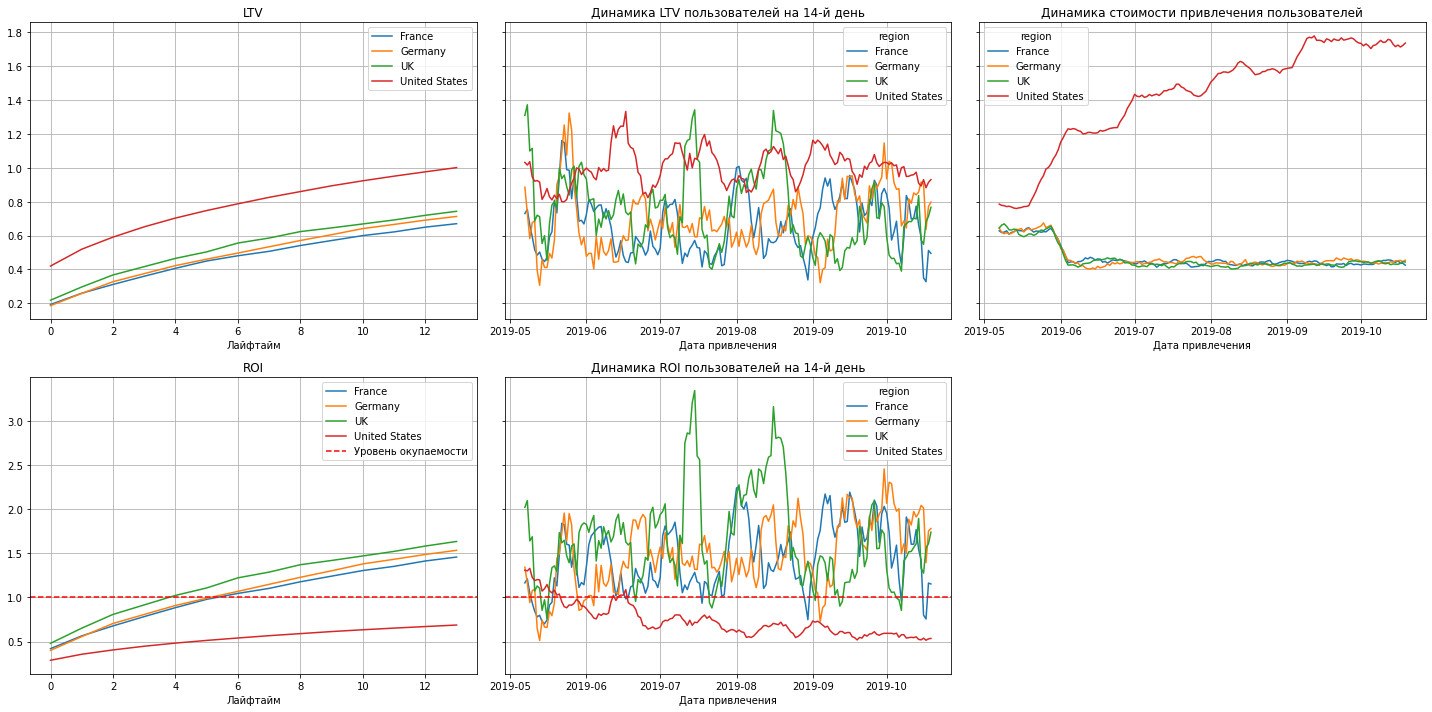

In [41]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    new_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

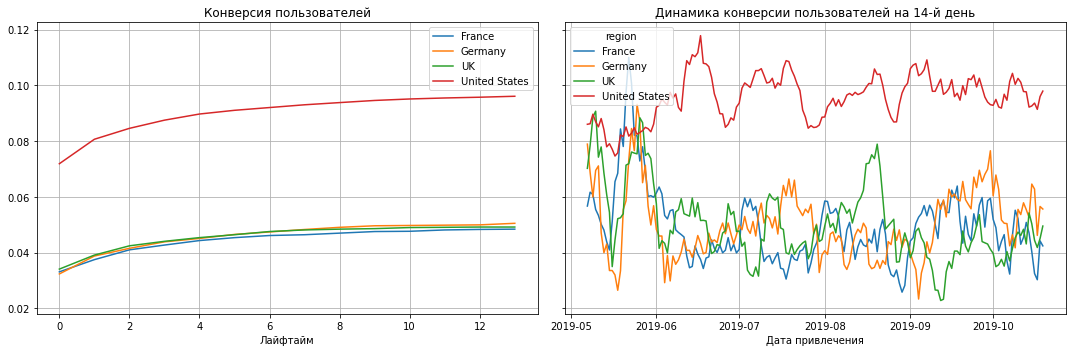

In [42]:
# конверсия с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    new_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

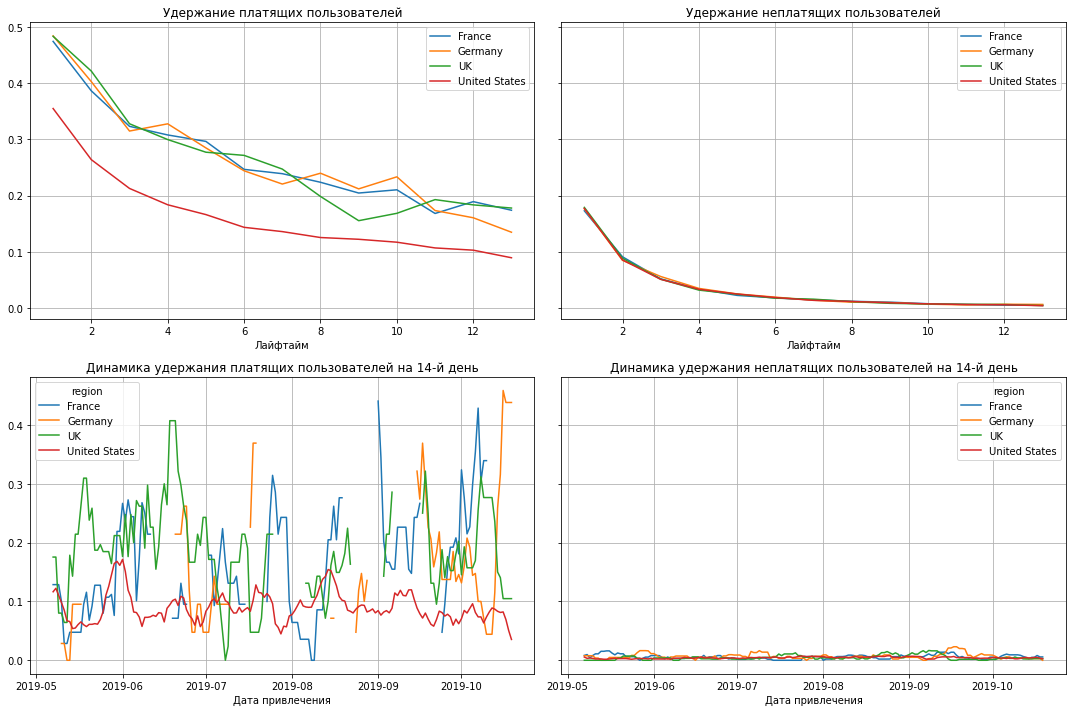

In [43]:
# удержание с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    new_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days)

<b>Вывод:</b>
Из графиков видно, что LTV стабилен. Как уже было выяснено, наибольший процент платящих пользоватей из США. Для США также видно аномально возросший САС с мая 2019. ROI показывает, что реклама в United States не окупается (60%).
Динамика ROI показывает, что с 2019-05 при резком увеличении трат на рекламу, ROI вышла за уровнь окупаемости.
Быстрее всего окупаются пользователи из UK (с 4 лайфтайма), потом Germany и France (на 5 лайфтайм.)
Пользователи из United States окупаются на 70%, вместе с тем их конверсия самая высокая, а удержание самое низкое.

<b> Разбивка по рекламным каналам.

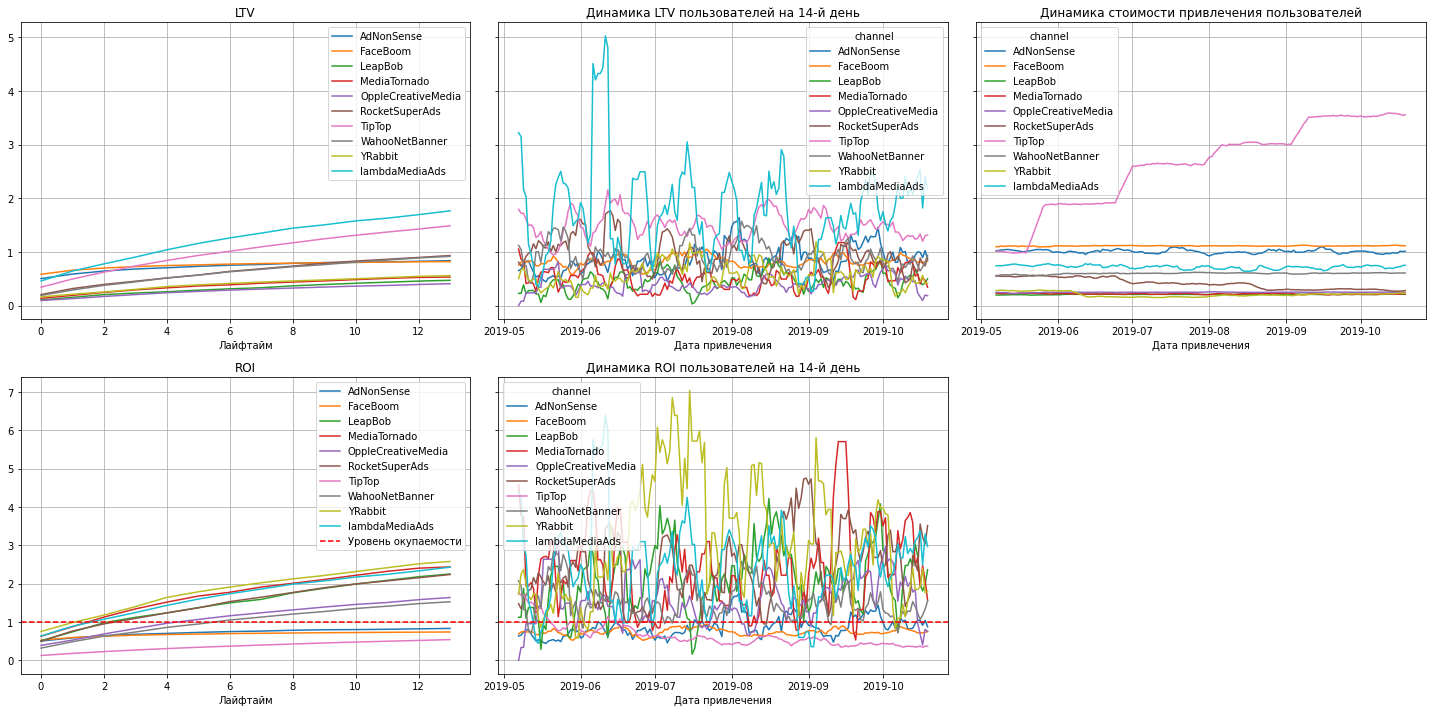

In [44]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    new_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

По графику LTV максимум у LambdaMediaAds, на втором месте - TipTop.
По графику CAC динамика стоимости привлечения пользователей по каналу TipTop растет аномольно быстро.
Самый быстро окупаемый канал - YRabbit.
Канал TipTop окупается примерно на 50%, а FaceBoom и AdNonSence окупаются на 80%.

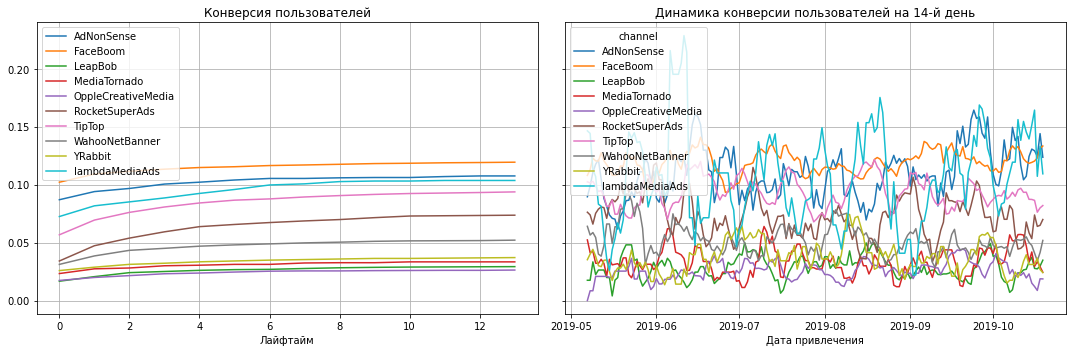

In [45]:
# конверсия с разбивкой по каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучшая конверсия пользователей у канала FaceBoom, следом AdNonSense и lambdaMediaAds.

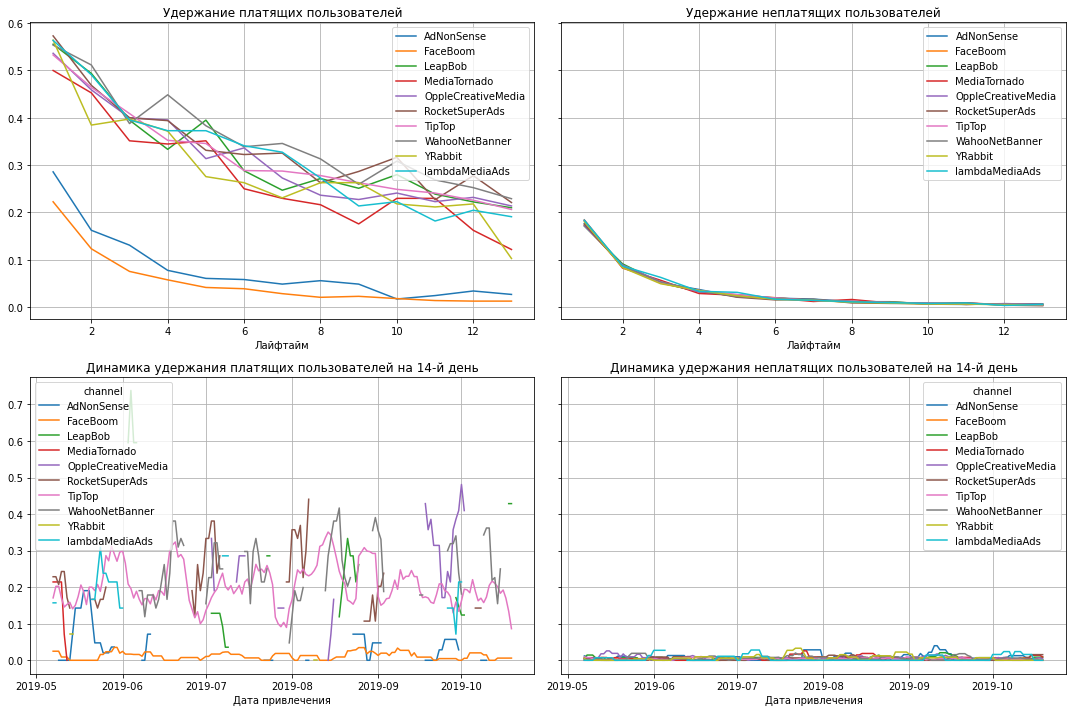

In [46]:
# удержание с разбивкой по рекламным каналам
retention_raw, retention_grouped, retention_history = get_retention(
    new_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days) 

А вот удержание платящих пользователей по каналам FaceBoom и AdNonSense самое низкое.

<b> Вывод:</b>
    По графику LTV максимум у LambdaMediaAds, на втором месте - TipTop.
По графику CAC динамика стоимости привлечения пользователей по каналу TipTop растет аномольно быстро.
Самый быстро окупаемый канал - YRabbit.
Канал TipTop окупается примерно на 50%, а FaceBoom и AdNonSence окупаются на 80%.
Лучшая конверсия пользователей у канала FaceBoom, следом AdNonSense и lambdaMediaAds. А вот удержание платящих пользователей по каналам FaceBoom и AdNonSense самое низкое.

### В результате анализа активности за полгода можно прийти к следующим выводам:</b>

<b>Причины неэффективности привлечения пользователей:</b>
<ol>
    <li>Завышенные расходы на канал TipTop.</li>
    <li>Низкий retention rate у каналов AdNonSense и FaceBoom.</li>
    <li>Завышенные расходы на рекламу по устройствам iPhone и Mac .</li>
    <li>Завышенные расходы на рекламу в США (малая окупаемость и удержание).</li>
</ol>

<b>Рекомендации для отдела маркетинга:</b>
<ol>
    <li>Разработать предложения для самой платежной группы - пользователей Mac и iPhone</li>
    <li>Снизить расходы на рекламу в США, также по каналам TipTop, AdNonSense и FaceBoom.</li>
    <li>Можно увеличить расходы на каналы YRabbit, lambdaMediaAds, WahooNetBanner и RocketSuperAds в перспективных регионах, например в Европе.</li>
    <li>Исключить завышенные расходы на рекламу в США (малая окупаемость и удержание).</li>
</ol>